# 목차
> ## 1. 필요한 라이브러리를 불러옵니다.
> ## 2. 데이터 전처리 및 토큰화
> ## 3. 임베딩
> ## 4. 모델학습
> ## 5. 결과 시각화
> ## 6. gensim 활용
> ## 7. Word2vec을 이용한 성능 향상
> ## 회고

## 1. 필요한 라이브러리를 불러옵니다.

In [135]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import tensorflow as tf
import gensim
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 상위 5개의 train 데이터를 보았는데, 띄어 쓰기가 없는 문장도 있고 한글이 아닌 문장도 있습니다.

## 2. 데이터 전처리 및 토큰화

In [2]:
len(train_data)

150000

* 트레인 데이터가 15만개가 있습니다.
* null 값을 확인해 보겠습니다.

In [3]:
print(train_data.isnull().values.any())# Null 값이 존재하는지 확인

True


* True가 나온걸 보니 null값이 있어 이를 제거 하고 남은 개수를 확인해 보겠습니다.

In [4]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data.isnull().values.any() # Null 값이 존재하는지 확인

False

In [5]:
len(train_data)

149995

* 5개가 제거 되었습니다.
* 추가로 한글과 공백을 제외하고 모두 제거해보겠습니다.

In [6]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [7]:
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


* 특수 문자들이 전부 제거 되었습니다.
* 혹시 한글로 안쓴 리뷰가 있다면 없어졌을테니 null값으로 바꾸고 개수를 확인해 보겠습니다.

In [8]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id             0
document    1255
label          0
dtype: int64

* 1255개나 있네요. 제거해보겠습니다.

In [9]:
train_data = train_data.dropna(how = 'any')
len(train_data)

148740

* 전처리를 완료했고 이제 토큰화 시키겠습니다.

In [10]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=19000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

* 단어장의 개수를 1000개씩 올려가며 정확도 체크를 했습니다.
* 그러다 19000개일때, 정확도가 대략 83%이상이 계속 나와 채택했습니다.

In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

* 이제 문장 분석을 해보겠습니다.

In [13]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[27, 67, 891, 33, 214, 15, 28, 698]
라벨:  0
1번째 리뷰 문장 길이:  8
2번째 리뷰 문장 길이:  13


In [14]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 143620, 테스트 개수: 49157


In [15]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  14.448144747558059
문장길이 최대 :  105
문장길이 표준편차 :  11.85959851440663
pad_sequences maxlen :  38
전체 문장의 0.935817032114827%가 maxlen 설정값 이내에 포함됩니다. 


* 맥시멈 길이를 38까지로 하면 어느정도 문장을 커버할 수 있습니다.

* 패딩처리를 하겠습니다.

In [16]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(143620, 38)


In [17]:
vocab_size = len(word_to_index)
word_vector_dim = 4

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value = word_to_index['<PAD>'],
                                                     padding = 'pre')

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                     value = word_to_index['<PAD>'],
                                                     padding = 'pre')

print(X_train)

[[   0    0    0 ...   15   28  698]
 [   0    0    0 ...   11   38  364]
 [   0    0    0 ...   19  192    2]
 ...
 [   0    0    0 ...    2 2650    5]
 [   0    0    0 ...   54  368 8186]
 [   0    0    0 ...   80 2608    4]]


* 앞쪽에 0이 생긴걸봐서 pre패딩이 잘 처리 된것 같습니다.

## 3. 임베딩

In [18]:
output = embedding(X_train)
print(output)

tf.Tensor(
[[[-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  [-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  [-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  ...
  [ 1.7512590e-05  7.2725900e-03 -2.9840529e-02  3.0109871e-02]
  [-2.8287148e-02 -4.2597797e-02 -1.1097305e-03 -4.8584141e-02]
  [-4.8761059e-02  2.8304789e-02 -9.3244091e-03 -1.1497892e-02]]

 [[-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  [-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  [-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  ...
  [-3.0771010e-03 -2.9118432e-02 -2.8990662e-02 -1.2108672e-02]
  [-1.2233447e-02 -1.5697800e-02  3.5439674e-02 -4.3186918e-03]
  [ 2.7526785e-02 -3.7037600e-02  4.6138231e-02  4.6707664e-02]]

 [[-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  [-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  [-1.9048525e-02  3.2058135e-03 -4.1408300e-02  4.5717668e-02]
  ...
  [ 1.7

## 4. 모델학습

### 글로벌 맥스풀링 모델

In [19]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d (Global (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


* validation 셋을 분리하겠습니다.

In [20]:
# validation set 50000만건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 93620건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(93620, 38)
(93620,)


* 모델 학습

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
183/183 [==============================] - 2s 8ms/step - loss: 0.6859 - accuracy: 0.5679 - val_loss: 0.6263 - val_accuracy: 0.6972
Epoch 2/10
183/183 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.7313 - val_loss: 0.5264 - val_accuracy: 0.7906
Epoch 3/10
183/183 [==============================] - 1s 5ms/step - loss: 0.5055 - accuracy: 0.8103 - val_loss: 0.4787 - val_accuracy: 0.8097
Epoch 4/10
183/183 [==============================] - 1s 5ms/step - loss: 0.4524 - accuracy: 0.8339 - val_loss: 0.4533 - val_accuracy: 0.8167
Epoch 5/10
183/183 [==============================] - 1s 5ms/step - loss: 0.4176 - accuracy: 0.8466 - val_loss: 0.4373 - val_accuracy: 0.8212
Epoch 6/10
183/183 [==============================] - 1s 5ms/step - loss: 0.3944 - accuracy: 0.8532 - val_loss: 0.4290 - val_accuracy: 0.8210
Epoch 7/10
183/183 [==============================] - 1s 5ms/step - loss: 0.3703 - accuracy: 0.8625 - val_loss: 0.4245 - val_accuracy: 0.8209
Epoch 

* 테스트 결과

In [22]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4291 - accuracy: 0.8170
[0.42907875776290894, 0.8169741630554199]


* 81.7%가 나왔습니다.

## 5. 결과 시각화

In [23]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


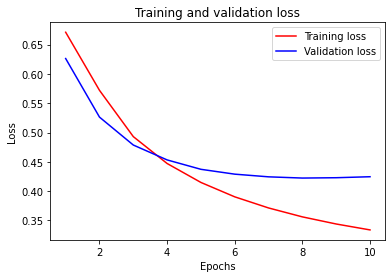

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "r"는 "빨간색 실선"입니다
plt.plot(epochs, loss, 'r', label='Training loss')
# "b"는 "파란색 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

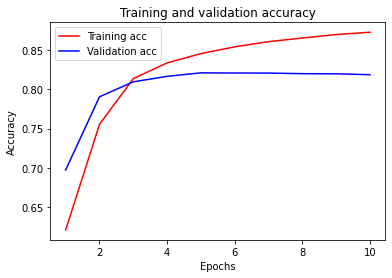

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 시각화 해서 보니 5번만 학습해도 충분할것 같습니다.

### RNN모델

In [26]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))# input_shape을 None으로 명시해주는 것은 음이 아닌 정수가 들어올것
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
183/183 [==============================] - 5s 12ms/step - loss: 0.6563 - accuracy: 0.6141 - val_loss: 0.4473 - val_accuracy: 0.8172
Epoch 2/5
183/183 [==============================] - 2s 10ms/step - loss: 0.4079 - accuracy: 0.8318 - val_loss: 0.3752 - val_accuracy: 0.8359
Epoch 3/5
183/183 [==============================] - 2s 10ms/step - loss: 0.3500 - accuracy: 0.8507 - val_loss: 0.3637 - val_accuracy: 0.8413
Epoch 4/5
183/183 [==============================] - 2s 10ms/step - loss: 0.3253 - accuracy: 0.8651 - val_loss: 0.3626 - val_accuracy: 0.8406
Epoch 5/5
183/183 [==============================] - 2s 10ms/step - loss: 0.3105 - accuracy: 0.8732 - val_loss: 0.3669 - val_accuracy: 0.8388


In [28]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.3808 - accuracy: 0.8301
[0.38084790110588074, 0.8301361203193665]


* 정확도가 83%가 나왔습니다.

### 1-D CNN 모델

In [29]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(4))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
183/183 [==============================] - 10s 33ms/step - loss: 0.6483 - accuracy: 0.6212 - val_loss: 0.3975 - val_accuracy: 0.8237
Epoch 2/5
183/183 [==============================] - 1s 7ms/step - loss: 0.3745 - accuracy: 0.8379 - val_loss: 0.3638 - val_accuracy: 0.8398
Epoch 3/5
183/183 [==============================] - 1s 7ms/step - loss: 0.3326 - accuracy: 0.8594 - val_loss: 0.3623 - val_accuracy: 0.8417
Epoch 4/5
183/183 [==============================] - 1s 7ms/step - loss: 0.3126 - accuracy: 0.8676 - val_loss: 0.3625 - val_accuracy: 0.8407
Epoch 5/5
183/183 [==============================] - 1s 7ms/step - loss: 0.2956 - accuracy: 0.8775 - val_loss: 0.3642 - val_accuracy: 0.8421


In [31]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3766 - accuracy: 0.8343
[0.37659236788749695, 0.8343267440795898]


* 정확도가 83.4%가 나왔습니다.

## 6. gensim을 활용한 유사 단어 찾기

In [32]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 4)


In [33]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

* 목소리의 벡터를 확인해 보겠습니다.

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['목소리']
vector

array([-0.05360135, -0.02246502, -0.0141776 ,  0.05046765], dtype=float32)

* 비슷한 단어를 확인해 보겠습니다.

In [35]:
word_vectors.similar_by_word("목소리")

[('보아', 0.9934581518173218),
 ('줘서', 0.9911131858825684),
 ('여군', 0.9843399524688721),
 ('만났', 0.9838072061538696),
 ('쟁쟁', 0.9810857772827148),
 ('음모론', 0.9801883697509766),
 ('쳐도', 0.9780040979385376),
 ('대작전', 0.977965772151947),
 ('잭슨', 0.9740726351737976),
 ('다리', 0.9734795689582825)]

* 공부할 길이 먼것 같습니다.

## 7. Word2vec을 이용한 성능 향상

In [36]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['목소리']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.8365737e+00, -2.2371593e+00,  6.4586264e-01, -1.3149614e+00,
       -5.5056995e-01, -8.8372332e-01, -4.4887072e-01, -5.9947234e-01,
       -1.8026084e+00, -2.9662672e-01, -1.8178902e+00,  5.2410360e-02,
       -6.8903780e-01,  1.8786483e+00, -6.4682728e-01,  8.4452546e-01,
       -1.2216880e-01,  1.7394070e-01,  8.5570806e-01, -1.3337194e+00,
        2.5691736e+00,  1.4252509e-01, -1.9240727e-01,  5.3854162e-01,
       -2.3123934e-03, -8.9955918e-02, -8.9582211e-01,  1.3948807e+00,
       -1.1426680e+00, -1.6856974e+00,  6.8861745e-02,  1.5816360e+00,
       -1.3951684e+00,  2.5441783e-02, -4.2950025e-01, -7.6981455e-01,
       -2.7157953e-01,  7.7424204e-01,  5.3073901e-01,  2.5676215e+00,
       -1.2482250e+00,  4.7452552e-03, -1.3607091e+00, -2.0171592e+00,
        3.4369293e-01, -3.4666055e-01, -3.4688485e-03, -1.6749820e-01,
       -1.9645364e+00,  1.1126209e-01, -1.1736035e+00,  4.6384707e-01,
        2.9114825e-01, -2.9395670e-01, -3.2165793e-01,  4.8373958e-01,
      

In [37]:
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [114]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))# input_shape을 None으로 명시해주는 것은 음이 아닌 정수가 들어올것
model.add(keras.layers.LSTM(128)) 
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [116]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=2  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=8,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/2
11703/11703 [==============================] - 224s 19ms/step - loss: 0.4261 - accuracy: 0.7993 - val_loss: 0.3302 - val_accuracy: 0.8536
Epoch 2/2
11703/11703 [==============================] - 222s 19ms/step - loss: 0.2846 - accuracy: 0.8775 - val_loss: 0.3257 - val_accuracy: 0.8596


In [117]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 7s - loss: 0.3339 - accuracy: 0.8520
[0.33387479186058044, 0.851984441280365]


* 하이퍼파라미터를 계속 변경해 가며 85.2%를 만들었습니다.

In [ ]:
new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
score = float(loaded_model.predict(pad_new)) # 예측

### 리뷰 테스트

In [149]:
sentence = "가슴이 웅장해진다."

* 긍정을 기계가 잘 판단하는지 보겠습니다.

In [130]:
okt = Okt()
sentence = okt.morphs(sentence, stem=True)
sentence

['가슴', '이', '웅장', '하다']

* 특수 문자가 없어 바로 토큰화했습니다.

In [131]:
sentence = [word for word in sentence if not word in stopwords]
sentence

['가슴', '웅장']

* 불용어를 제거했습니다.

In [151]:
encoded = get_encoded_sentence(sentence, word_to_index)
encoded

[1, 2, 2]

* 임베딩했습니다.

In [152]:
decoded = get_decoded_sentence(encoded, index_to_word)
decoded

'<UNK> <UNK>'

* 다시 한글로 바꿔보니, 단어장에 없는 단어였습니다.<br/>유의미한 결과가 나올것 같진 않네요

In [157]:
pad = keras.preprocessing.sequence.pad_sequences([encoded],
                                                 value = word_to_index['<PAD>'],
                                                 padding = 'pre',
                                                 maxlen=maxlen)
pad

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2]], dtype=int32)

* 패딩했습니다.

In [160]:
score = float(model.predict(pad))
score

0.3947201371192932

* 39.4%확률로 긍정이라고 합니다 <br/>15%확률로 틀렸나 봅니다

## 회고

* 이번 노드 개인적으로 데이터 전처리와 하이퍼파라미터의 변경만으로 목표치를 달성하고 싶었고, 달성했습니다.
* 1-D CNN 모델의 학습과정중 오류가 발생했는데, 레이어에 비하여 input의 사이즈가 작아서 생긴 에러였고 맥스풀링파라미터를 변경하여 해결하였습니다.
* TF마스터에서 조원들의 도움으로 양방향 LSTM과 Dropout을 활용하는 방법도 알게되어서 나중에 활용해 보고 싶습니다.